# Backtesting Trading Swing Trading Strategies

options-trading/
├── 1_Initial_analysis.ipynb           # Your existing notebook for market data analysis
├── main_backtest.py                   # Main script to run and compare strategies
├── utils/
│   ├── market_data_analysis.py        # Your existing market data download/indicator functions
│   └── plot_market_data.py            # Your existing plotting functions for market data
└── backtesting/
    ├── backtest_stocks.py             # Contains backtesting functions for stocks
    ├── plot_backtest.py               # Contains plotting functions for portfolio and strategy comparison
    └── plot_trade_signals.py          # Plots buy & sell signals on the price chart

## backtest_stocks

In [39]:
# backtesting/backtest_stocks.py

import pandas as pd
import random
from utils.market_data_analysis import download_tranform

def compute_macd_signal(df, signal_span=9):
    """
    Computes the MACD signal line as the EMA of the MACD.
    Assumes the DataFrame already has a 'MACD' column.
    """
    df = df.copy()
    df['Signal'] = df['MACD'].ewm(span=signal_span, adjust=False).mean()
    return df

def generate_signals(df):
    """
    Generates trading signals based solely on MACD crossovers.
    
    Strategy (long-only):
      - Buy when MACD crosses above its Signal line.
      - Sell when MACD crosses below its Signal line.
    
    Adds the following column:
      - 'SignalFlag': 1 for buy, -1 for sell, 0 otherwise.
    """
    df = df.copy()
    df['SignalFlag'] = 0

    for i in range(1, len(df)):
        # Buy signal: MACD crosses above Signal
        if (df.loc[i-1, 'MACD'] < df.loc[i-1, 'Signal']) and (df.loc[i, 'MACD'] > df.loc[i, 'Signal']):
            df.loc[i, 'SignalFlag'] = 1
        # Sell signal: MACD crosses below Signal
        elif (df.loc[i-1, 'MACD'] > df.loc[i-1, 'Signal']) and (df.loc[i, 'MACD'] < df.loc[i, 'Signal']):
            df.loc[i, 'SignalFlag'] = -1
        else:
            df.loc[i, 'SignalFlag'] = 0

    return df

def prepare_backtest_data(stock_symbol='AAPL', data_period='1y'):
    """
    Prepares data for backtesting:
      1. Downloads and processes market data using your existing download_tranform().
      2. Computes the MACD signal line.
      3. Generates buy/sell signals based solely on MACD.
      
    Returns a DataFrame ready for simulation.
    """
    df = download_tranform(stock_symbol, data_period)
    df = compute_macd_signal(df)
    df = generate_signals(df)
    return df

def simulate_trades(df, initial_capital=100000):
    """
    Simulates trades based on the MACD strategy.
    Uses a fixed budget and goes all-in when a buy signal occurs and sells all on a sell signal.
    
    Returns:
      - Updated DataFrame with columns: 'PortfolioValue', 'Cash', 'Shares'.
      - A trade log DataFrame with trade details.
    """
    cash = initial_capital
    shares = 0
    buy_price = None

    portfolio_values = []
    cash_history = []
    shares_history = []
    trade_log = []

    for index, row in df.iterrows():
        current_price = row['c_price']
        portfolio_value = cash + shares * current_price
        portfolio_values.append(portfolio_value)
        cash_history.append(cash)
        shares_history.append(shares)

        signal = row['SignalFlag']
        if signal == 1 and shares == 0:
            # Buy all-in: purchase as many shares as possible.
            shares_to_buy = int(cash // current_price)
            if shares_to_buy > 0:
                buy_price = current_price
                cash -= shares_to_buy * current_price
                shares = shares_to_buy
                trade_log.append({
                    'Date': row['date'],
                    'Action': 'Buy',
                    'Shares': shares_to_buy,
                    'Price': current_price,
                    'Signal': signal,
                    'PnL': None
                })
        elif signal == -1 and shares > 0:
            sell_price = current_price
            pnl = (sell_price - buy_price) * shares
            cash += shares * sell_price
            trade_log.append({
                'Date': row['date'],
                'Action': 'Sell',
                'Shares': shares,
                'Price': sell_price,
                'Signal': signal,
                'PnL': pnl
            })
            shares = 0
            buy_price = None

    df['PortfolioValue'] = portfolio_values
    df['Cash'] = cash_history
    df['Shares'] = shares_history
    trade_df = pd.DataFrame(trade_log)
    return df, trade_df

def backtest_buy_and_hold(df, initial_capital=100000):
    """
    Simulates a simple buy-and-hold strategy.
    
    Assumes the entire budget is invested on the first day.
    Returns an updated DataFrame with 'PortfolioValueBH'.
    For compatibility in comparisons, it also copies this column to 'PortfolioValue'.
    """
    df = df.copy()
    df['MarketReturn'] = df['c_price'].pct_change()
    df['PortfolioValueBH'] = (1 + df['MarketReturn']).cumprod() * initial_capital
    # Set PortfolioValue equal to the buy-and-hold portfolio value for consistent plotting.
    df['PortfolioValue'] = df['PortfolioValueBH']
    return df

def simulate_random_strategy(df, initial_capital=100000, chunk_size=5000):
    """
    Simulates a random strategy with fixed monetary chunks.
    
    At each iteration, a random decision is made:
      - 60% chance: No action.
      - 20% chance: Execute a Buy chunk.
      - 20% chance: Execute a Sell chunk.
    
    Rules:
      - Buy: If cash >= chunk_size, purchase shares worth 'chunk_size' at the current price.
      - Sell: If shares are held and current price > average cost,
          sell shares worth 'chunk_size'.  
          Otherwise (if current price <= average cost), do not sell; instead, buy another chunk to lower the average cost.
    
    Maintains:
      - cash: Available cash.
      - shares: Number of shares held.
      - avg_cost: Average purchase price.
    
    Returns:
      - Updated DataFrame with 'PortfolioValue', 'Cash', 'Shares', 'AvgCost'.
      - A trade log DataFrame with trade details.
    """
    cash = initial_capital
    shares = 0
    avg_cost = None

    portfolio_values = []
    cash_history = []
    shares_history = []
    avg_cost_history = []
    trade_log = []

    for index, row in df.iterrows():
        current_price = row['c_price']
        portfolio_value = cash + shares * current_price
        portfolio_values.append(portfolio_value)
        cash_history.append(cash)
        shares_history.append(shares)
        avg_cost_history.append(avg_cost if avg_cost is not None else 0)

        r = random.random()
        if r < 0.6:
            action = "None"
        elif r < 0.8:
            action = "Buy"
        else:
            action = "Sell"

        if action == "Buy":
            if cash >= chunk_size:
                shares_to_buy = int(chunk_size // current_price)
                if shares_to_buy > 0:
                    if shares == 0:
                        avg_cost = current_price
                    else:
                        avg_cost = (shares * avg_cost + shares_to_buy * current_price) / (shares + shares_to_buy)
                    cash -= shares_to_buy * current_price
                    shares += shares_to_buy
                    trade_log.append({
                        'Date': row['date'],
                        'Action': 'Buy',
                        'Shares': shares_to_buy,
                        'Price': current_price,
                        'Chunk': chunk_size,
                        'NewAvgCost': avg_cost,
                        'Signal': action
                    })
        elif action == "Sell":
            if shares > 0:
                if current_price > avg_cost:
                    shares_to_sell = int(chunk_size // current_price)
                    if shares_to_sell > shares:
                        shares_to_sell = shares
                    if shares_to_sell > 0:
                        cash += shares_to_sell * current_price
                        pnl = (current_price - avg_cost) * shares_to_sell
                        trade_log.append({
                            'Date': row['date'],
                            'Action': 'Sell',
                            'Shares': shares_to_sell,
                            'Price': current_price,
                            'Chunk': chunk_size,
                            'PnL': pnl,
                            'Signal': action
                        })
                        shares -= shares_to_sell
                        if shares == 0:
                            avg_cost = None
                else:
                    # Do not sell at a loss; instead, if cash is available, buy another chunk to average down.
                    if cash >= chunk_size:
                        shares_to_buy = int(chunk_size // current_price)
                        if shares_to_buy > 0:
                            if shares == 0:
                                avg_cost = current_price
                            else:
                                avg_cost = (shares * avg_cost + shares_to_buy * current_price) / (shares + shares_to_buy)
                            cash -= shares_to_buy * current_price
                            shares += shares_to_buy
                            trade_log.append({
                                'Date': row['date'],
                                'Action': 'Buy (Averaging Down)',
                                'Shares': shares_to_buy,
                                'Price': current_price,
                                'Chunk': chunk_size,
                                'NewAvgCost': avg_cost,
                                'Signal': action
                            })
        # No action if "None".
    df['PortfolioValue'] = portfolio_values
    df['Cash'] = cash_history
    df['Shares'] = shares_history
    df['AvgCost'] = avg_cost_history
    trade_df = pd.DataFrame(trade_log)
    return df, trade_df


## plot_backtest

In [48]:
# backtesting/plot_backtest.py

import matplotlib.pyplot as plt

def plot_portfolio_comparison(dfs, labels, symbol):
    """
    Plots the portfolio value curves of multiple strategies on a single figure.
    
    Parameters:
      dfs: List of DataFrames, each containing a 'PortfolioValue' column.
      labels: List of labels corresponding to each strategy.
      symbol: Stock symbol for the title.
    """
    plt.figure(figsize=(12,4))
    for df, label in zip(dfs, labels):
        plt.plot(df['date'], df['PortfolioValue'], label=label)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title(f'Portfolio Value Comparison for {symbol}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_portfolio_components(df, symbol):
    """
    Plots cash held and shares held on two separate subplots within the same figure.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    
    ax1.plot(df['date'], df['Cash'], label='Cash Held', color='green')
    ax1.set_ylabel('Cash Held')
    ax1.legend(loc='upper left')
    
    ax2.plot(df['date'], df['Shares'], label='Shares Held', color='blue')
    ax2.set_ylabel('Shares Held')
    ax2.set_xlabel('Date')
    ax2.legend(loc='upper left')
    
    plt.suptitle(f'{symbol} - Portfolio Components Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## trade_log

In [22]:
# backtesting/trade_log.py

import pandas as pd

def generate_trade_log(df):
    """
    Generates a trade log DataFrame from the backtested DataFrame.
    
    The input DataFrame `df` is expected to have:
      - 'date': The date of the observation.
      - 'c_price': The closing price.
      - 'SignalFlag': 1 for a buy signal, -1 for a sell signal, 0 otherwise.
    
    The output DataFrame contains the following columns:
      - 'Date': The date of the trade event.
      - 'Action': 'Buy' or 'Sell'.
      - 'Price': The price at which the trade occurred.
      - 'SignalFlag': The signal value that triggered the action.
      - 'PnL': The profit and loss for a sell event (None for buy events).
    
    The function assumes a long-only strategy:
      - A trade is entered on a buy signal (SignalFlag == 1).
      - It is closed on the subsequent sell signal (SignalFlag == -1).
      - The PnL is computed as (exit price - entry price) for each closed trade.
    """
    trades = []
    entry_price = None
    entry_date = None

    # Iterate through the DataFrame row by row.
    for index, row in df.iterrows():
        signal = row['SignalFlag']
        
        # If a buy signal is encountered and there is no open trade, record the buy.
        if signal == 1 and entry_price is None:
            entry_price = row['c_price']
            entry_date = row['date']
            trades.append({
                'Date': row['date'],
                'Action': 'Buy',
                'Price': row['c_price'],
                'SignalFlag': signal,
                'PnL': None
            })
        # If a sell signal is encountered and a trade is open, record the sell and compute PnL.
        elif signal == -1 and entry_price is not None:
            exit_price = row['c_price']
            pnl = exit_price - entry_price  # absolute profit/loss per share
            trades.append({
                'Date': row['date'],
                'Action': 'Sell',
                'Price': row['c_price'],
                'SignalFlag': signal,
                'PnL': pnl
            })
            # Reset for the next trade.
            entry_price = None
            entry_date = None

    trade_df = pd.DataFrame(trades)
    return trade_df


## plot_trade_signal

In [50]:
# backtesting/plot_trade_signals.py

import matplotlib.pyplot as plt

def plot_trade_signals(df, symbol):
    """
    Plots the stock's closing price with markers for buy and sell signals.
    
    Buy signals (SignalFlag == 1) are marked with green upward arrows,
    and sell signals (SignalFlag == -1) are marked with red downward arrows.
    """
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df['c_price'], label='Close Price', color='blue')
    
    # Identify buy and sell signal rows.
    buy_signals = df[df['SignalFlag'] == 1]
    sell_signals = df[df['SignalFlag'] == -1]
    
    plt.plot(buy_signals['date'], buy_signals['c_price'], '^', markersize=10, color='green', label='Buy Signal')
    plt.plot(sell_signals['date'], sell_signals['c_price'], 'v', markersize=10, color='red', label='Sell Signal')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{symbol} - Buy & Sell Signals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## download data

In [1]:
from backtesting.backtest_stocks import (
    prepare_backtest_data,
    simulate_macd_strategy,
    simulate_random_strategy,
    backtest_buy_and_hold
)
from backtesting.plot_backtest import plot_portfolio_comparison, plot_portfolio_components
from backtesting.plot_trade_signals import plot_trade_signals



symbol = 'AAPL'
data_period = '3y'
initial_capital = 100000  # Configurable budget
chunk_size = 5000         # Configurable chunk size for random strategy

# Prepare base data using your existing market data functions.
df_base = prepare_backtest_data(stock_symbol=symbol, data_period=data_period)



Starting download and transformation process for AAPL with data period 3y...
Connecting to IBKR...
IBKR connection established.
Created stock contract for AAPL.
Fetching IV data from IBKR...
IV data fetched: 752 records retrieved.
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price data downloaded: 753 records retrieved.
Merging price and IV data...
Data merged: 752 records in the merged dataset.
Computing technical indicators...
Technical indicators computed successfully.
Disconnecting from IBKR...
Disconnected from IBKR.
Download and transformation process completed.


## Run Backtest

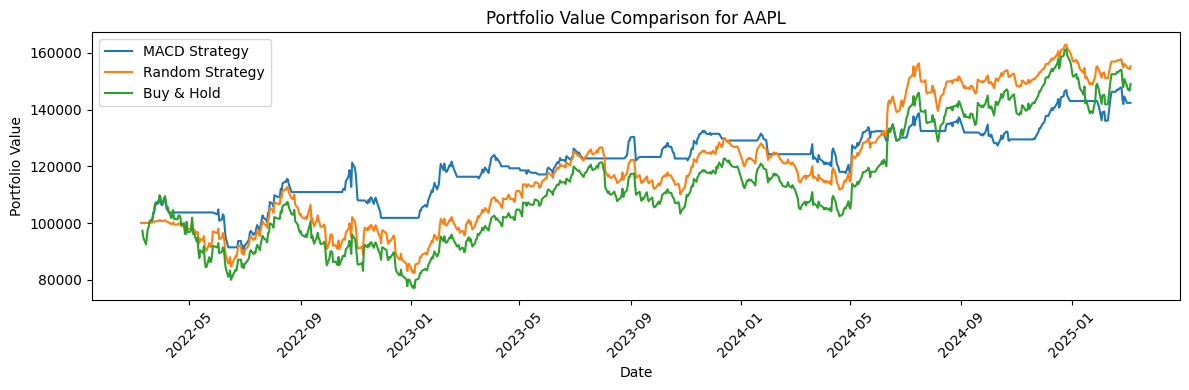

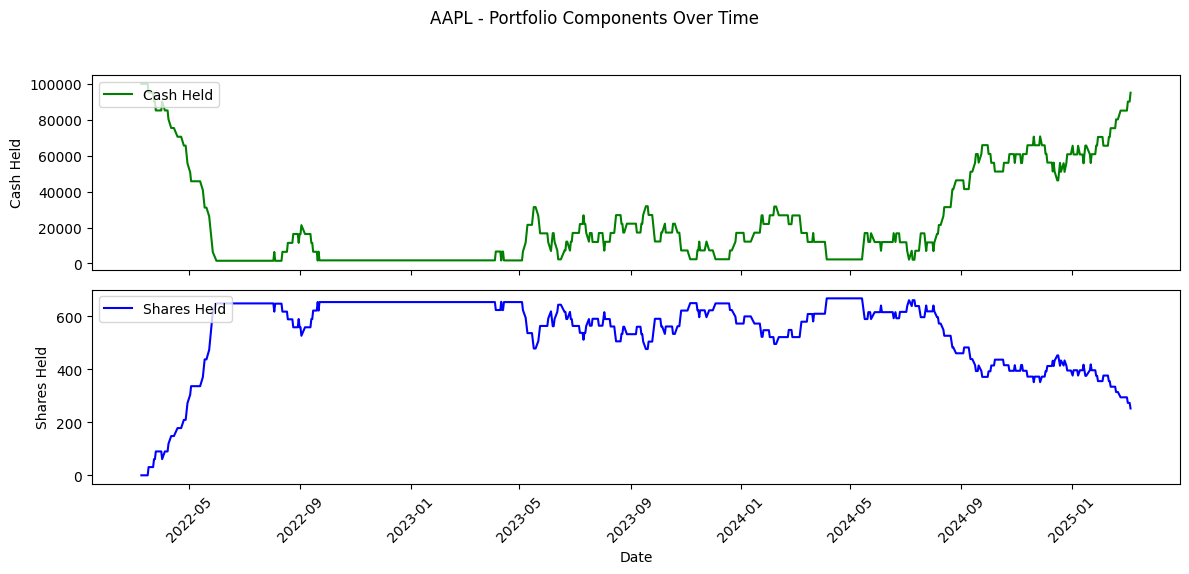

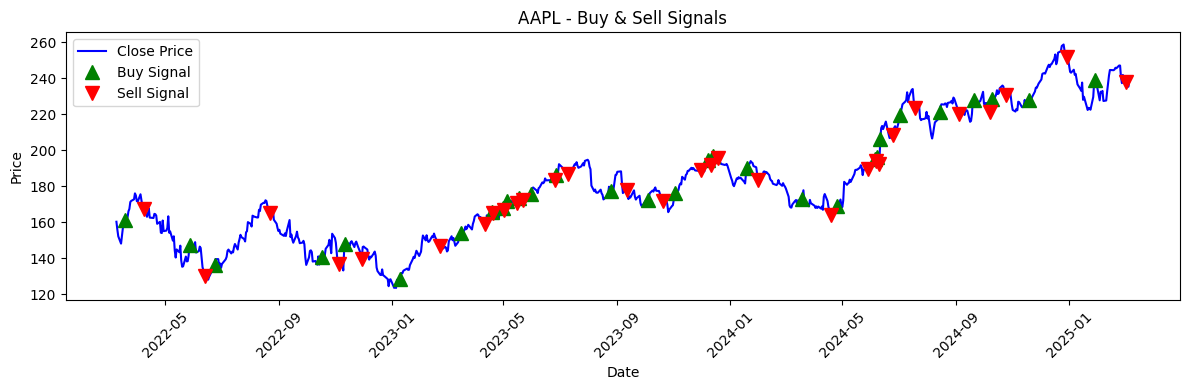

MACD Strategy Trade Log:
         Date Action  Shares       Price  Signal           PnL
0  2022-03-18    Buy     619  161.365295       1           NaN
1  2022-04-08   Sell     619  167.377884      -1   3721.792282
2  2022-05-27    Buy     703  147.470306       1           NaN
3  2022-06-13   Sell     703  129.967834      -1 -12304.237762
4  2022-06-23    Buy     670  136.265182       1           NaN
5  2022-08-22   Sell     670  165.369736      -1  19500.050659
6  2022-10-17    Buy     789  140.540085       1           NaN
7  2022-11-04   Sell     789  136.789536      -1  -2959.183411
8  2022-11-11    Buy     729  147.979446       1           NaN
9  2022-11-29   Sell     729  139.547501      -1  -6146.888489
10 2023-01-09    Buy     791  128.654144       1           NaN
11 2023-02-21   Sell     791  146.997574      -1  14509.652786
12 2023-03-16    Buy     753  154.293961       1           NaN
13 2023-04-11   Sell     753  159.194565      -1   3690.154999
14 2023-04-19    Buy     723  

In [3]:

# Run MACD strategy simulation.
df_macd, trade_log_macd = simulate_macd_strategy(df_base.copy(), initial_capital=initial_capital)

# Run randomized chunk strategy simulation.
df_random, trade_log_random = simulate_random_strategy(df_base.copy(), initial_capital=initial_capital, chunk_size=chunk_size)

# Run buy-and-hold simulation.
df_bh = backtest_buy_and_hold(df_base.copy(), initial_capital=initial_capital)

# Plot portfolio value comparison for the three strategies.
plot_portfolio_comparison(
    [df_macd, df_random, df_bh],
    ['MACD Strategy', 'Random Strategy', 'Buy & Hold'],
    symbol
)

# Plot portfolio components (cash and shares) for the Random strategy.
plot_portfolio_components(df_random, symbol)

# Plot trade signals for the MACD strategy.
plot_trade_signals(df_macd, symbol)

# Print trade logs for inspection.
print("MACD Strategy Trade Log:")
print(trade_log_macd)
print("\nRandom Strategy Trade Log:")
print(trade_log_random)



Total PnL from trades:
42410.2265625
Unrealized PnL:
42410.2265625
Realized PnL:
42410.2265625
